In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sklearn
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = yfinance.download(
    tickers="^GSPC ^FTSE ^N225 ^GDAXI", 
    start="1994-01-07",
    end="2019-09-01",
    interval="1d",
    group_by='ticker',
    auto_adjust=True,
    treads=True
)

[*********************100%***********************]  4 of 4 completed


In [3]:
df_comp = raw_data.copy(deep=True)

In [4]:
df_comp = df_comp.assign(
    spx = df_comp['^GSPC'].Close,
    dax = df_comp['^FTSE'].Close,
    ftse = df_comp['^N225'].Close,
    nikkei = df_comp['^GDAXI'].Close
)

df_comp

^N225                                            \
                    Open          High           Low         Close   
Date                                                                 
1994-01-06           NaN           NaN           NaN           NaN   
1994-01-07  17842.980469  18131.410156  17787.480469  18124.009766   
1994-01-10  18186.519531  18567.060547  18186.519531  18443.439453   
1994-01-11  18481.849609  18671.669922  18373.039062  18485.250000   
1994-01-12  18447.339844  18807.080078  18301.929688  18793.880859   
...                  ...           ...           ...           ...   
2019-08-26  20325.439453  20329.009766  20173.759766  20261.039062   
2019-08-27  20467.220703  20529.939453  20439.919922  20456.080078   
2019-08-28  20474.310547  20511.210938  20433.310547  20479.419922   
2019-08-29  20500.500000  20520.679688  20361.119141  20460.929688   
2019-08-30  20641.490234  20748.349609  20633.300781  20704.369141   

                              ^FTSE                                         \
                Volume         Open         High          Low        Close   
Date                                                                         
1994-01-06         NaN  3355.300049  3407.699951  3355.300049  3403.000000   
1994-01-07         0.0  3401.399902  3446.800049  3398.699951  3446.000000   
1994-01-10         0.0  3465.699951  3468.100098  3430.000000  3440.600098   
1994-01-11         0.0  3442.500000  3442.500000  3413.500000  3413.800049   
1994-01-12         0.0  3394.800049  3402.399902  3372.000000  3372.000000   
...                ...          ...          ...          ...          ...   
2019-08-26  69900000.0          NaN          NaN          NaN          NaN   
2019-08-27  60800000.0  7095.000000  7110.799805  7044.700195  7089.600098   
2019-08-28  51500000.0  7089.600098  7131.200195  7050.000000  7114.700195   
2019-08-29  55100000.0  7114.700195  7199.200195  7103.100098  7184.299805   
2019-08-30  72000000.0  7184.299805  7240.399902  7179.700195  7207.200195   

                         ...      ^GDAXI        ^GSPC               \
                 Volume  ...      Volume         Open         High   
Date                     ...                                         
1994-01-06          0.0  ...         0.0   467.549988   469.000000   
1994-01-07          0.0  ...         0.0   467.089996   470.260010   
1994-01-10          0.0  ...         0.0   469.899994   475.269989   
1994-01-11          0.0  ...         0.0   475.269989   475.279999   
1994-01-12          0.0  ...         0.0   474.130005   475.059998   
...                 ...  ...         ...          ...          ...   
2019-08-26          NaN  ...  54752500.0  2866.699951  2879.270020   
2019-08-27  851399100.0  ...  82363700.0  2893.139893  2898.790039   
2019-08-28  675638900.0  ...  59962600.0  2861.280029  2890.030029   
2019-08-29  635681800.0  ...  72992700.0  2910.370117  2930.500000   
2019-08-30  727868800.0  ...  77686500.0  2937.090088  2940.429932   

                                                            spx          dax  \
                    Low        Close        Volume                             
Date                                                                           
1994-01-06   467.019989   467.119995  3.659600e+08   467.119995  3403.000000   
1994-01-07   467.029999   469.899994  3.249200e+08   469.899994  3446.000000   
1994-01-10   469.549988   475.269989  3.194900e+08   475.269989  3440.600098   
1994-01-11   473.269989   474.130005  3.054900e+08   474.130005  3413.800049   
1994-01-12   472.140015   474.170013  3.106900e+08   474.170013  3372.000000   
...                 ...          ...           ...          ...          ...   
2019-08-26  2856.000000  2878.379883  2.857600e+09  2878.379883          NaN   
2019-08-27  2860.590088  2869.159912  3.533630e+09  2869.159912  7089.600098   
2019-08-28  2853.050049  2887.939941  3.097420e+09  2887.939941  7114.700195   
2019

In [5]:
df_comp = df_comp[1:]
df_comp.drop(columns=['^GSPC', '^FTSE', '^N225', '^GDAXI'], inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')
df_comp

,spx,dax,ftse,nikkei
,,,,
Date,,,,
1994-01-07,469.899994,3446.000000,18124.009766,2224.949951
1994-01-10,475.269989,3440.600098,18443.439453,2225.000000
1994-01-11,474.130005,3413.800049,18485.250000,2228.100098
1994-01-12,474.170013,3372.000000,18793.880859,2182.060059
1994-01-13,472.470001,3360.000000,18577.259766,2142.370117
...,...,...,...,...
2019-08-26,2878.379883,7095.000000,20261.039062,11658.040039
2019-08-27,2869.159912,7089.600098,20456.080078,11730.019531


In [6]:
df_comp.isnull().sum()

spx         0
dax         0
ftse        0
nikkei      0
dtype: int64

In [7]:
df_comp = df_comp.assign(
    ret_spx = df_comp['spx'].pct_change(1).mul(100),
    ret_ftse = df_comp['ftse'].pct_change(1).mul(100),
    ret_dax = df_comp['dax'].pct_change(1).mul(100),
    ret_nikkei = df_comp['nikkei'].pct_change(1).mul(100),
)
df_comp

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei
,,,,,,,,
Date,,,,,,,,
1994-01-07,469.899994,3446.000000,18124.009766,2224.949951,NaN,NaN,NaN,NaN
1994-01-10,475.269989,3440.600098,18443.439453,2225.000000,1.142795,1.762467,-0.156701,0.002249
1994-01-11,474.130005,3413.800049,18485.250000,2228.100098,-0.239860,0.226696,-0.778935,0.139330
1994-01-12,474.170013,3372.000000,18793.880859,2182.060059,0.008438,1.669606,-1.224443,-2.066336
1994-01-13,472.470001,3360.000000,18577.259766,2142.370117,-0.358524,-1.152615,-0.355872,-1.818921
...,...,...,...,...,...,...,...,...
2019-08-26,2878.379883,7095.000000,20261.039062,11658.040039,1.098299,-2.172145,0.000000,0.400725
2019-08-27,2869.159912,7089.600098,20456.080078,11730.019531,-0.320318,0.962641,-0.076109,0.617424


In [8]:
df_comp = df_comp.assign(
    norm_ret_spx = df_comp['ret_spx'].div(df_comp['ret_spx'][1])*100,
    norm_ret_ftse = df_comp['ret_ftse'].div(df_comp['ret_ftse'][1])*100,
    norm_ret_dax = df_comp['ret_dax'].div(df_comp['ret_dax'][1])*100,
    norm_ret_nikkei = df_comp['ret_nikkei'].div(df_comp['ret_nikkei'][1])*100,
)
df_comp

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
1994-01-07,469.899994,3446.000000,18124.009766,2224.949951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-10,475.269989,3440.600098,18443.439453,2225.000000,1.142795,1.762467,-0.156701,0.002249,100.000000,100.000000,100.000000,100.000000
1994-01-11,474.130005,3413.800049,18485.250000,2228.100098,-0.239860,0.226696,-0.778935,0.139330,-20.988914,12.862428,497.085111,6194.007011
1994-01-12,474.170013,3372.000000,18793.880859,2182.060059,0.008438,1.669606,-1.224443,-2.066336,0.738392,94.731198,781.390409,-91860.185677
1994-01-13,472.470001,3360.000000,18577.259766,2142.370117,-0.358524,-1.152615,-0.355872,-1.818921,-31.372527,-65.397822,227.103092,-80861.183055
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-26,2878.379883,7095.000000,20261.039062,11658.040039,1.098299,-2.172145,0.000000,0.400725,96.106342,-123.244604,-0.000000,17814.483944
2019-08-27,2869.159912,7089.600098,20456.080078,11730.019531,-0.320318,0.962641,-0.076109,0.617424,-28.029347,54.618937,48.569415,27447.928201


In [9]:
def splitting_data(df, train_size):
    size = int(df.shape[0] * train_size)
    return df.iloc[:size], df.iloc[size:]
    
train_df, test_df = splitting_data(df_comp, .8)

In [10]:
display(train_df)
display(test_df)

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
1994-01-07,469.899994,3446.000000,18124.009766,2224.949951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-10,475.269989,3440.600098,18443.439453,2225.000000,1.142795,1.762467,-0.156701,0.002249,100.000000,100.000000,100.000000,100.000000
1994-01-11,474.130005,3413.800049,18485.250000,2228.100098,-0.239860,0.226696,-0.778935,0.139330,-20.988914,12.862428,497.085111,6194.007011
1994-01-12,474.170013,3372.000000,18793.880859,2182.060059,0.008438,1.669606,-1.224443,-2.066336,0.738392,94.731198,781.390409,-91860.185677
1994-01-13,472.470001,3360.000000,18577.259766,2142.370117,-0.358524,-1.152615,-0.355872,-1.818921,-31.372527,-65.397822,227.103092,-80861.183055
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-07-08,1963.709961,6738.500000,15314.410156,9772.669922,-0.704880,-0.422839,-1.245695,-1.346653,-61.680354,-23.991315,794.952349,-59866.246313
2014-07-09,1972.829956,6718.000000,15302.650391,9808.200195,0.464427,-0.076789,-0.304222,0.363568,40.639543,-4.356898,194.142222,16162.615912


,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-07-15,1973.280029,6710.500000,15395.160156,9719.410156,-0.193210,0.642878,-0.527714,-0.650103,-16.906752,36.476013,336.765641,-28900.695507
2014-07-16,1981.569946,6784.700195,15379.299805,9859.269531,0.420108,-0.103022,1.105733,1.438970,36.761482,-5.845311,-705.634059,63970.243920
2014-07-17,1958.119995,6738.299805,15370.259766,9753.879883,-1.183403,-0.058781,-0.683897,-1.068940,-103.553334,-3.335130,436.435775,-47520.341116
2014-07-18,1978.219971,6749.500000,15215.709961,9720.019531,1.026494,-1.005512,0.166217,-0.347148,89.823046,-57.051394,-106.072947,-15432.645957
2014-07-21,1973.630005,6728.399902,15215.709961,9612.049805,-0.232025,0.000000,-0.312617,-1.110797,-20.303290,0.000000,199.499693,-49381.149705
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-26,2878.379883,7095.000000,20261.039062,11658.040039,1.098299,-2.172145,0.000000,0.400725,96.106342,-123.244604,-0.000000,17814.483944
2019-08-27,2869.159912,7089.600098,20456.080078,11730.019531,-0.320318,0.962641,-0.076109,0.617424,-28.029347,54.618937,48.569415,27447.928201


In [11]:
model_arima = ARIMA(train_df['ftse'], order=(1,0,0))
results_arima = model_arima.fit()
results_arima

SIMPLE FORECASTING

In [19]:
start_date = '2014-07-15'
end_date = '2019-10-23'

Text(0.5, 1.0, 'Prediction Vs Actual')

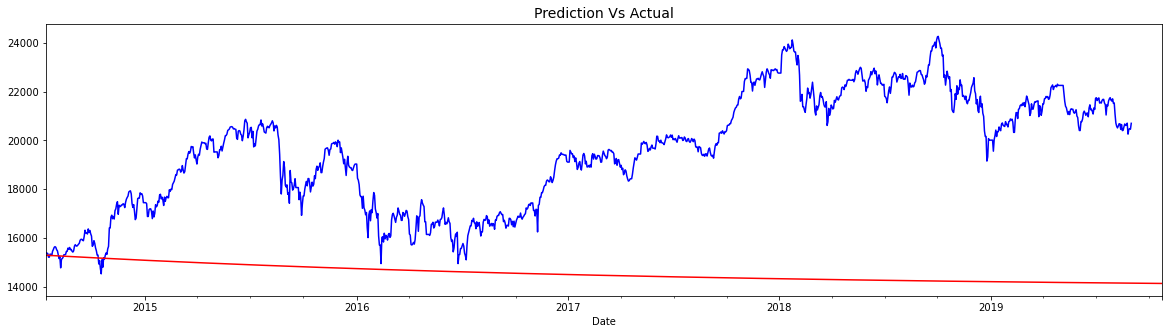

In [20]:
df_pred = results_arima.predict(start=start_date, end=end_date)
test_df.loc[start_date:end_date, 'ftse'].plot(color='blue')
df_pred[start_date:end_date].plot(figsize=(20,5), color='red')
plt.title('Prediction Vs Actual', size='14')

## AR MODEL AREN'T THE BEST ESTIMATORS OF NON-STATIONARY DATA

Text(0.5, 1.0, 'Prediction Vs Actual')

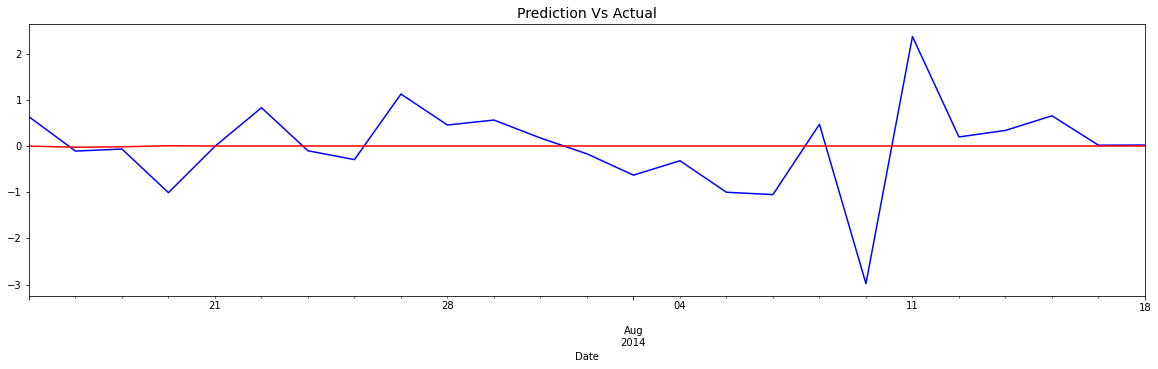

In [21]:
end_date = '2014-08-18'

model_ret_ar = ARIMA(train_df['ret_ftse'][1:], order=(5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start=start_date, end=end_date)

test_df.loc[start_date:end_date, 'ret_ftse'].plot(color='blue')
df_pred_ar[start_date:end_date].plot(figsize=(20,5), color='red')
plt.title('Prediction Vs Actual', size='14')

Our model makes no predictions sixe it assume all future returns will be 0, or extremely close to it

In [15]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                     ARMA(1, 0)   Log Likelihood               -9674.202
Method:                       css-mle   S.D. of innovations              1.475
Date:                Thu, 03 Mar 2022   AIC                          19354.404
Time:                        07:51:00   BIC                          19374.159
Sample:                    01-10-1994   HQIC                         19361.304
                         - 07-14-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0077      0.020      0.396      0.692      -0.031       0.046
ar.L1.ret_ftse    -0.0324      0.014     -2.369      0.018      -0.059      -0.006
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -30.8928           +0.0000j           30.8928            0.5000
-----------------------------------------------------------------------------
"""

In [23]:
df_pred_ar.head()

2014-07-15    0.005102
2014-07-16   -0.019276
2014-07-17   -0.009977
2014-07-18    0.012327
2014-07-21    0.006682
Freq: B, dtype: float64

## ARMA

Text(0.5, 1.0, 'Prediction Vs Actual')

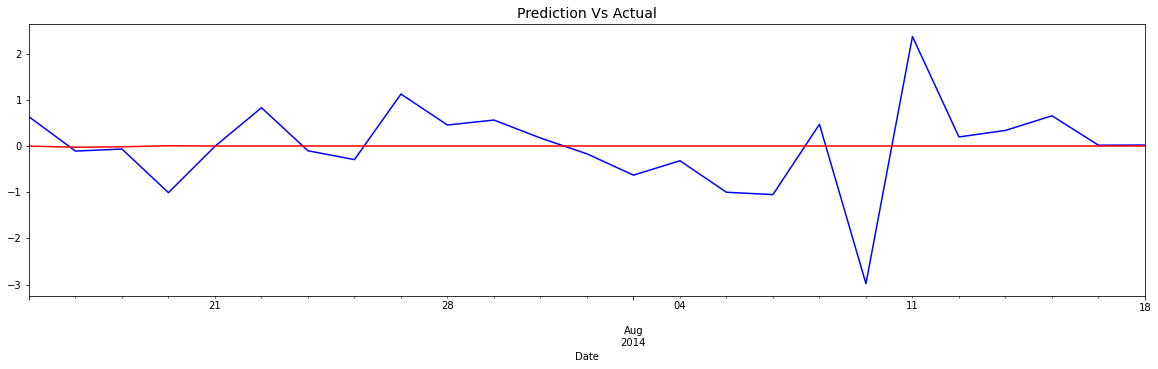

In [24]:
model_ret_ar = ARIMA(train_df['ret_ftse'][1:], order=(5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start=start_date, end=end_date)

test_df.loc[start_date:end_date, 'ret_ftse'].plot(color='blue')
df_pred_ar[start_date:end_date].plot(figsize=(20,5), color='red')
plt.title('Prediction Vs Actual', size='14')

## ARMAX

Text(0.5, 1.0, 'Prediction Vs Actual (Returns)')

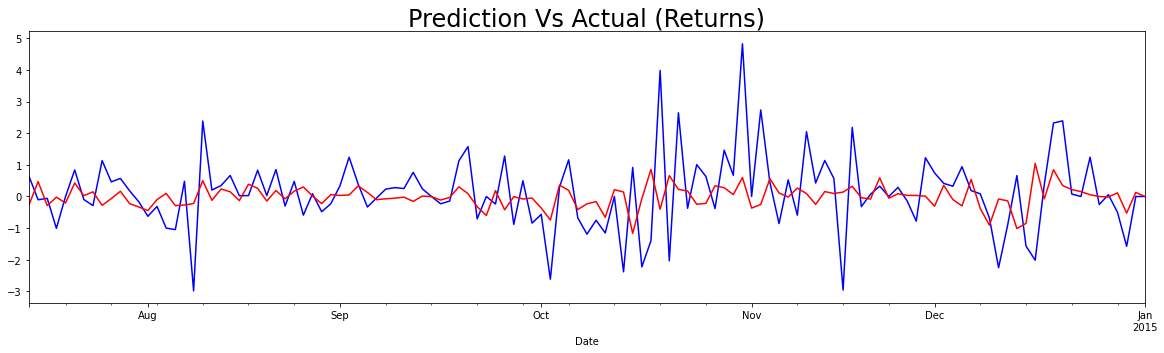

In [31]:
end_date = '2015-01-01'
model_ret_armax = ARIMA(
    train_df['ret_ftse'][1:], 
    exog=train_df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], 
    order=(1,0,1)
)

results_ret_armax = model_ret_armax.fit()
df_pred_armax = results_ret_armax.predict(
    start=start_date, 
    end=end_date,
    exog=test_df[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]
)

test_df.loc[start_date:end_date, 'ret_ftse'].plot(color='blue')
df_pred_armax[start_date:end_date].plot(figsize=(20,5), color='red')
plt.title('Prediction Vs Actual (Returns)', size='24')

## SARMA

Text(0.5, 1.0, 'Prediction Vs Actual (SARMA)')

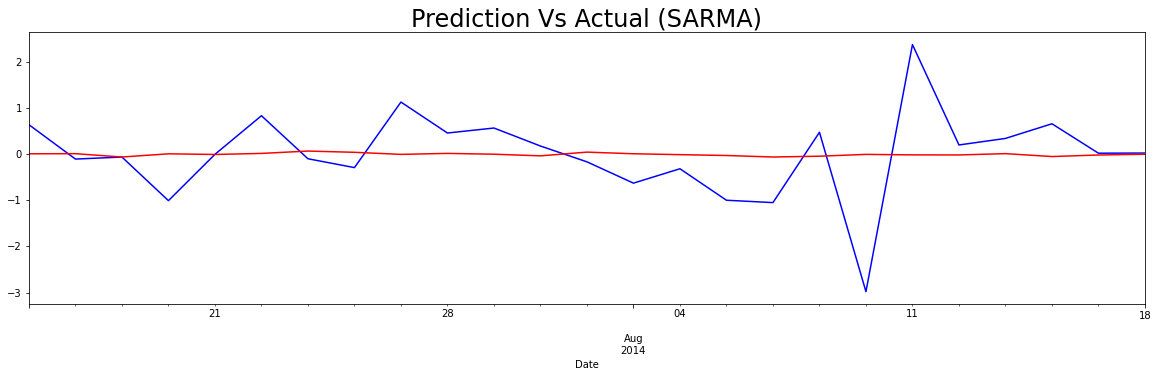

In [34]:
end_date = '2014-08-18'
model_ret_sarma = SARIMAX(
    train_df['ret_ftse'][1:], 
    order=(3,0,4),
    seasonal_order=(3,0,2,5)
)

results_ret_sarma = model_ret_sarma.fit()
df_pred_sarma = results_ret_sarma.predict(
    start=start_date, 
    end=end_date,
)

test_df.loc[start_date:end_date, 'ret_ftse'].plot(color='blue')
df_pred_sarma[start_date:end_date].plot(figsize=(20,5), color='red')
plt.title('Prediction Vs Actual (SARMA)', size='24')

## SARIMAX

Text(0.5, 1.0, 'Prediction Vs Actual (SARMA)')

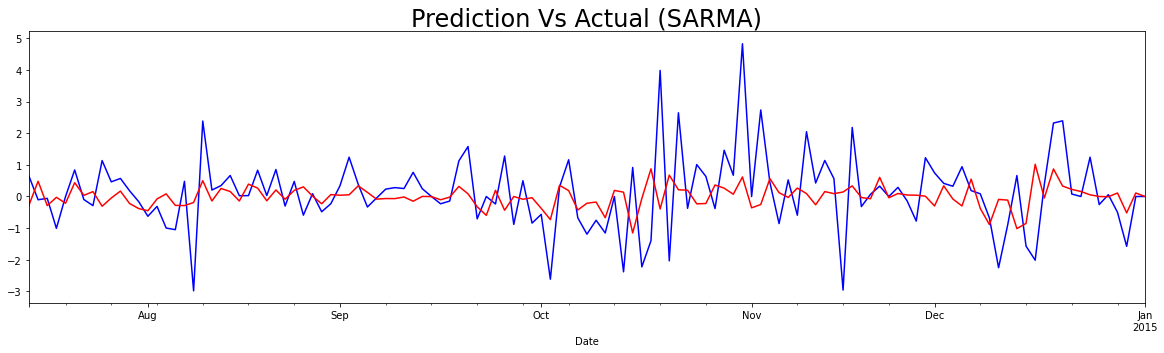

In [35]:
end_date = '2015-01-01'
model_ret_sarimax = SARIMAX(
    train_df['ret_ftse'][1:], 
    order=(3,0,4),
    exog=train_df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
    seasonal_order=(3,0,2,5)
)

results_ret_sarimax = model_ret_sarimax.fit()
df_pred_sarimax = results_ret_sarimax.predict(
    start=start_date,
    end=end_date,
    exog=test_df[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date],
)

test_df.loc[start_date:end_date, 'ret_ftse'].plot(color='blue')
df_pred_sarimax[start_date:end_date].plot(figsize=(20,5), color='red')
plt.title('Prediction Vs Actual (SARIMAX)', size='24')

## AUTO ARIMA

In [48]:
from pmdarima.arima import auto_arima

model_auto = auto_arima(
    train_df['ret_ftse'][1:],
    exogenous=train_df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
    m=5,
    max_p=5,
    max_q=5,
    max_P=5,
    max_Q=5
)

In [50]:
df_auto_pred = pd.DataFrame(
    model_auto.predict(
        n_periods=len(test_df[start_date:end_date]),
        exogenous=test_df[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]
    ),
    index=test_df[start_date:end_date].index
)

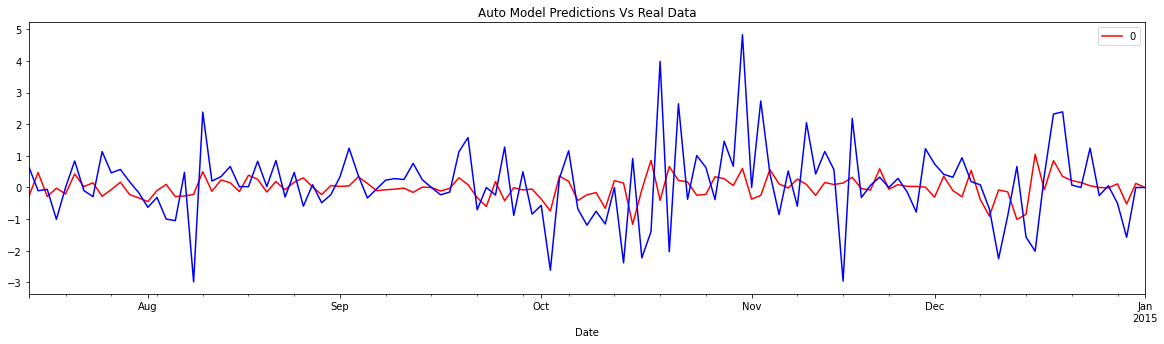

In [51]:
df_auto_pred.plot(figsize=(20,5), color='red')
test_df.loc[start_date:end_date, 'ret_ftse'].plot(color='blue')
plt.title('Auto Model Predictions Vs Real Data')
plt.show()

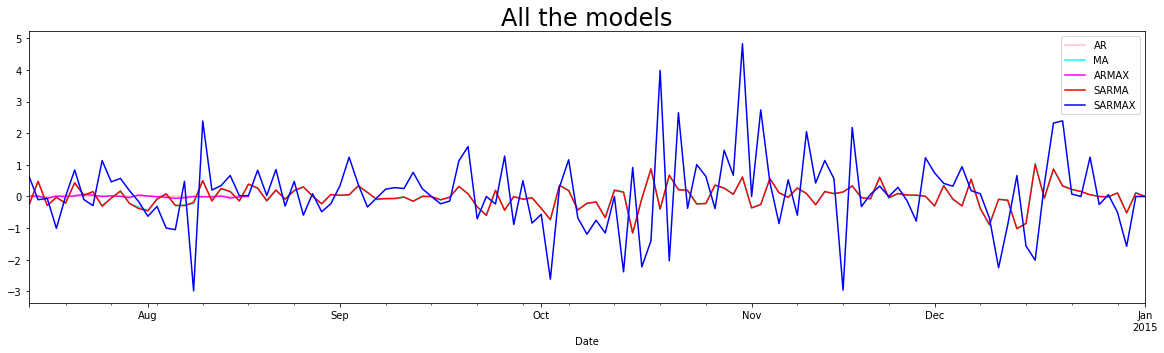

In [53]:
# df_pred[start_date:end_date].plot(figsize=(20,5), color='yellow')
df_pred_ar[start_date:end_date].plot(color='pink')
df_pred_armax[start_date:end_date].plot(color='cyan')
df_pred_sarma[start_date:end_date].plot(color='magenta')
df_pred_sarimax[start_date:end_date].plot(figsize=(20,5), color='red')
test_df.loc[start_date:end_date, 'ret_ftse'].plot(color='blue')
plt.legend(['AR', 'MA', 'ARMAX', 'SARMA', 'SARMAX'])
plt.title('All the models', size=24)
plt.show()

### DISCUSS HOW TO USE THE ARCH PACKAGE TO FORECAST VOLATILITY

In [57]:
mod_garch = arch_model(df_comp['ret_ftse'][1:], vol='GARCH', p=1, q=1, mean='constant', dist='Normal')
res_garch = mod_garch.fit(last_obs=start_date, update_freq=10)

Iteration:     10,   Func. Count:     65,   Neg. LLF: 9097.426555656692
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9097.426495967538
            Iterations: 12
            Function evaluations: 74
            Gradient evaluations: 12


In [58]:
pred_garch = res_garch.forecast(horizon=1, align='target')

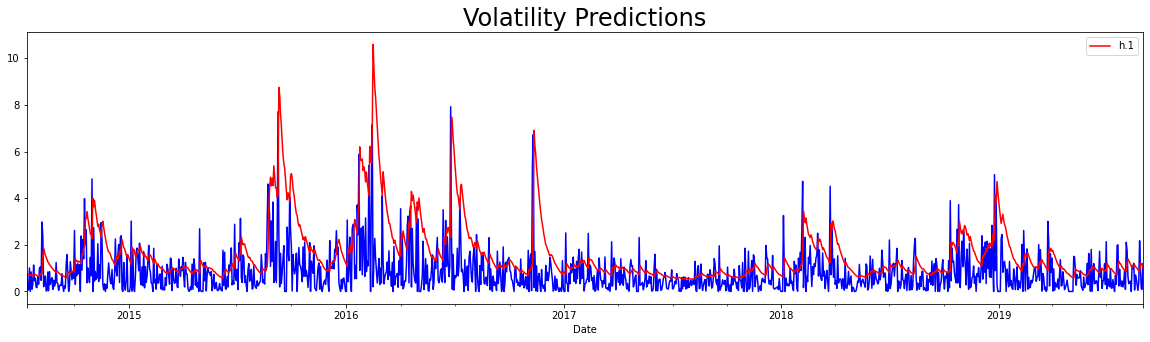

In [61]:
pred_garch.residual_variance[start_date:].plot(figsize=(20,5), color='red')
test_df['ret_ftse'].abs().plot(color='blue', zorder=1)
plt.title('Volatility Predictions', size=24)
plt.show()

In [62]:
pred_garch = res_garch.forecast(horizon=100, align='target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-30,1.041493,1.134152,1.232985,1.262433,0.937426,0.996376,1.068553,1.135348,1.192535,1.237909,...,1.936905,1.946667,1.958441,1.971948,1.986382,1.998019,2.000737,2.01518,2.030457,2.019992


## Multivariate Regression Model

In [63]:
from statsmodels.tsa.api import VAR

In [75]:
df_ret = train_df[['ret_spx', 'ret_dax', 'ret_nikkei', 'ret_ftse']][1:]

In [76]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic='aic')

In [77]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 03, Mar, 2022
Time:                     09:30:33
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.329002
Nobs:                     5346.00    HQIC:                  0.261684
Log likelihood:          -30861.5    FPE:                    1.25301
AIC:                     0.225548    Det(Omega_mle):         1.23351
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.039217         0.016160            2.427           0.015
L1.ret_spx           -0.110842         0.017560           -6.312           0.000
L1.ret_dax           -0.012983         0.024445           

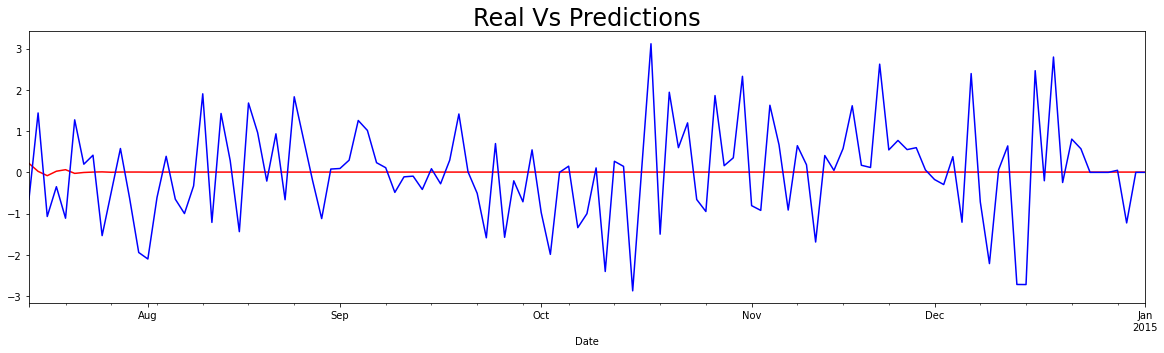

In [79]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(test_df[start_date:end_date]))

df_ret_pred = pd.DataFrame(data=var_pred_ret, index=test_df[start_date:end_date].index,
                          columns=test_df[start_date:end_date].columns[4:8])
df_ret_pred.loc[start_date:end_date, 'ret_nikkei'].plot(figsize=(20,5), color='red')
test_df['ret_nikkei'][start_date:end_date].plot(color='blue')
plt.title('Real Vs Predictions', size=24)
plt.show()

In [74]:
var_pred_ret

array([[ 2.05124437e-02,  7.90075775e-02,  1.11567664e-01],
       [-1.16692908e-05, -2.56816033e-03, -1.73964771e-02],
       [-1.38015123e-01, -1.32735208e-01, -5.63583066e-02],
       [-3.23312926e-02,  8.23217454e-02,  1.00238150e-01],
       [-1.78415988e-02, -1.08445384e-01, -1.43589057e-01],
       [ 8.21924452e-03,  7.61365255e-02,  7.52009850e-03],
       [ 3.95221891e-02,  6.56281700e-02,  8.48318542e-02],
       [ 4.71387958e-02,  1.89182685e-02,  6.49626730e-02],
       [ 1.38753981e-02, -5.43976317e-02, -6.11781674e-02],
       [ 4.57785508e-02,  8.29866265e-02,  7.99746534e-02],
       [-1.01016870e-01, -6.40475044e-02,  2.73252902e-02],
       [-6.79806580e-02, -5.00057714e-02, -1.09596035e-01],
       [-1.78110775e-02, -6.27223730e-02, -4.93286565e-02],
       [ 5.05808521e-02,  1.76941221e-01,  1.81659995e-01],
       [ 9.23974659e-02,  6.28526153e-03,  6.64521165e-02],
       [ 1.83246957e-01,  1.33543855e-01,  1.37895355e-01],
       [-6.93922657e-03,  6.13175069e-02